In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import matplotlib.pyplot as plt

In [15]:
df_brent = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view')
df_brent

[    0                                                  1
 0 NaN  PreÃ§o por barril do petrÃ³leo bruto Brent (FO...,
                                                    0
 0  Data  PreÃ§o - petrÃ³leo bruto - Brent (FOB)  ...,
                 0                                       1
 0            Data  PreÃ§o - petrÃ³leo bruto - Brent (FOB)
 1      28/04/2025                                    6613
 2      25/04/2025                                    6699
 3      24/04/2025                                    6750
 4      23/04/2025                                    6826
 ...           ...                                     ...
 11407  26/05/1987                                    1863
 11408  25/05/1987                                    1860
 11409  22/05/1987                                    1855
 11410  21/05/1987                                    1845
 11411  20/05/1987                                    1863
 
 [11412 rows x 2 columns],
       0   1
 0  Data NaN,
          

In [16]:
df_brent = df_brent[2]
df_brent = pd.DataFrame(df_brent)

In [17]:
df_brent.columns = ['Data', 'Preço Brent FOB (US$/barril)']
df_brent = df_brent.drop([0, 1])

In [18]:
df_brent['Data'] = pd.to_datetime(df_brent['Data'], format='%d/%m/%Y')
df_brent

,Data,Preço Brent FOB (US$/barril)
2,2025-04-25,6699
3,2025-04-24,6750
4,2025-04-23,6826
5,2025-04-22,6893
6,2025-04-17,6933
...,...,...
11407,1987-05-26,1863
11408,1987-05-25,1860
11409,1987-05-22,1855
11410,1987-05-21,1845


In [19]:
df_brent['Preço Brent FOB (US$/barril)_Corrigido'] = df_brent['Preço Brent FOB (US$/barril)'].apply(lambda x: f"{str(x)[:-2]}.{str(x)[-2:]}")
df_brent['Preço Brent FOB (US$/barril)_Corrigido'] = df_brent['Preço Brent FOB (US$/barril)_Corrigido'].astype(float)
df_brent.drop(columns=['Preço Brent FOB (US$/barril)'], inplace=True)
df_brent

,Data,Preço Brent FOB (US$/barril)_Corrigido
2,2025-04-25,66.99
3,2025-04-24,67.50
4,2025-04-23,68.26
5,2025-04-22,68.93
6,2025-04-17,69.33
...,...,...
11407,1987-05-26,18.63
11408,1987-05-25,18.60
11409,1987-05-22,18.55
11410,1987-05-21,18.45


<Axes: title={'center': 'Preço Brent FOB (US$/barril)'}, xlabel='Data'>

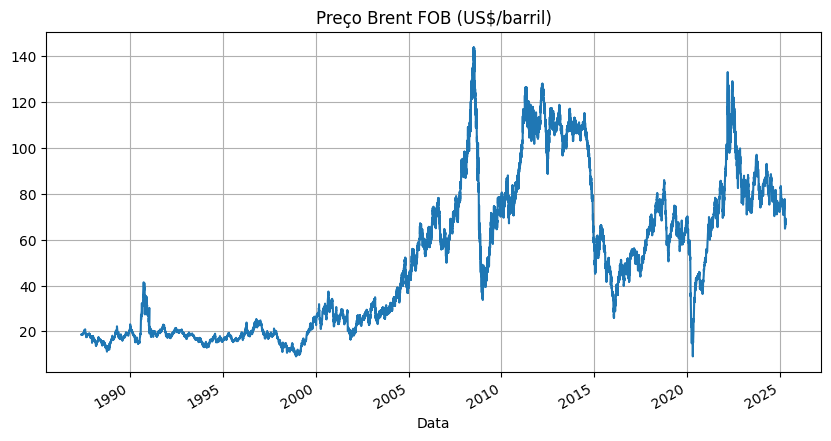

In [20]:
df_brent.plot(x='Data', y='Preço Brent FOB (US$/barril)_Corrigido', title='Preço Brent FOB (US$/barril)', figsize=(10, 5), grid=True, legend=False)

In [21]:
df_brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11410 entries, 2 to 11411
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Data                                    11410 non-null  datetime64[ns]
 1   Preço Brent FOB (US$/barril)_Corrigido  11410 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 178.4 KB


In [22]:
# Criar a previsão utlizando o Prophet

# Ajustando a base para o Prophet
## De acordo com a documentação da biblioteca, eles precisam de apenas duas colunas a de data (ds) e a do target (y)
df_brent_prophet = df_brent.copy()
df_brent_prophet.columns = ['ds', 'y']
df_brent_prophet


,ds,y
2,2025-04-25,66.99
3,2025-04-24,67.50
4,2025-04-23,68.26
5,2025-04-22,68.93
6,2025-04-17,69.33
...,...,...
11407,1987-05-26,18.63
11408,1987-05-25,18.60
11409,1987-05-22,18.55
11410,1987-05-21,18.45


In [23]:
df_brent

,Data,Preço Brent FOB (US$/barril)_Corrigido
2,2025-04-25,66.99
3,2025-04-24,67.50
4,2025-04-23,68.26
5,2025-04-22,68.93
6,2025-04-17,69.33
...,...,...
11407,1987-05-26,18.63
11408,1987-05-25,18.60
11409,1987-05-22,18.55
11410,1987-05-21,18.45


In [24]:
# Treinando o modelo
## Importei todos os dados porém não pretendo usar tudo. Por isso, criei uma coluna de ano para alterar o periodo utilizado o quanto
## que isso mellhorou a na acuracidade do modelo

year = 2022 # A intenção aqui ée que o usuário escolha o ano para treinar o modelo

df_brent_prophet['year'] = df_brent_prophet['ds'].dt.year

df_prophet_model = Prophet()
df_prophet_model.fit(df_brent_prophet.query('year >=' + str(year) + 'and year < 2025'))


16:00:47 - cmdstanpy - INFO - Chain [1] start processing
16:00:47 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Criando Forecast
## Ao criar a predição com o modelo, escolhi apenas as colunas de 'yhat' (predição), 'yhat_lower' (Menor valor do intervalo de predição) e 'yhat_upper' (Maior valor do
## intervalo de predição)


df_brent_forecast = df_prophet_model.predict(df_prophet_model.make_future_dataframe(periods=90))
df_brent_forecast = df_brent_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_brent_forecast['year'] = df_brent_forecast['ds'].dt.year

df_brent_forecast

,ds,yhat,yhat_lower,yhat_upper,year
0,2022-01-03,84.602645,78.922467,90.310267,2022
1,2022-01-04,84.640236,78.750618,90.639582,2022
2,2022-01-05,84.600271,78.714040,90.693377,2022
3,2022-01-06,84.950038,78.988056,90.661001,2022
4,2022-01-07,85.592760,80.268832,91.247235,2022
...,...,...,...,...,...
845,2025-03-27,79.964449,72.946855,87.399936,2025
846,2025-03-28,80.396223,72.747130,87.456641,2025
847,2025-03-29,77.333720,70.549019,83.938014,2025
848,2025-03-30,72.529859,65.545894,80.032919,2025


Text(83.22222222222221, 0.5, 'Brent (US$/barril)')

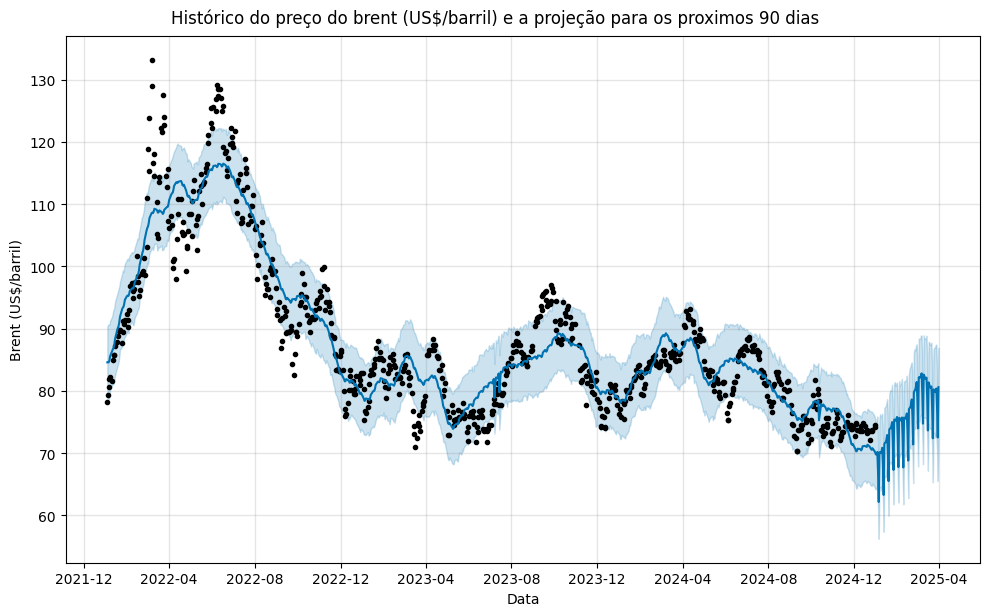

In [26]:
# Plotando o gráfico com os dados do brent e a previsão

df_brent_forecast_Fig = df_prophet_model.plot(df_brent_forecast)
df_brent_forecast_Fig.suptitle('Histórico do preço do brent (US$/barril) e a projeção para os proximos 90 dias', y = 1.02) 
df_brent_forecast_Fig.gca().set_xlabel('Data') 
df_brent_forecast_Fig.gca().set_ylabel('Brent (US$/barril)')

In [30]:
df_brent_forecast_25


,Data,Preço Brent FOB (US$/barril)_Corrigido,ds,yhat,year
0,2025-04-25,66.99,NaT,NaN,NaN
1,2025-04-24,67.50,NaT,NaN,NaN
2,2025-04-23,68.26,NaT,NaN,NaN
3,2025-04-22,68.93,NaT,NaN,NaN
4,2025-04-17,69.33,NaT,NaN,NaN
...,...,...,...,...,...
11405,1987-05-26,18.63,NaT,NaN,NaN
11406,1987-05-25,18.60,NaT,NaN,NaN
11407,1987-05-22,18.55,NaT,NaN,NaN
11408,1987-05-21,18.45,NaT,NaN,NaN


In [ ]:
# Adiculando os dados do brent com a previsão
## A previsão é feita para 90 dias, então a previsão começa no dia 01/01/2025 e vai até o dia 31/03/2025

df_brent_forecast_25 = df_brent_forecast.query('year >= 2025')
df_brent_forecast_25 = df_brent_forecast_25.drop(columns=['yhat_lower','yhat_upper'])

df_brent_forecast_25 = df_brent.merge(
    df_brent_forecast_25,
    left_on='Data',
    right_on='ds',
    how='inner'
)
df_brent_forecast_25

,Data,Preço Brent FOB (US$/barril)_Corrigido,ds,yhat,year
0,2025-03-31,77.23,2025-03-31,80.608617,2025
1,2025-03-28,74.69,2025-03-28,80.396223,2025
2,2025-03-27,74.72,2025-03-27,79.964449,2025
3,2025-03-26,74.60,2025-03-26,79.824934,2025
4,2025-03-25,73.78,2025-03-25,80.077152,2025
...,...,...,...,...,...
58,2025-01-08,77.37,2025-01-08,70.014620,2025
59,2025-01-07,77.84,2025-01-07,70.124471,2025
60,2025-01-06,77.27,2025-01-06,70.161324,2025
61,2025-01-03,76.72,2025-01-03,70.206429,2025


In [32]:
# Removendo as colunas que não são mais necessárias
df_brent_forecast_25.drop(columns=['ds'], inplace=True)

In [33]:
df_brent_forecast_25

,Data,Preço Brent FOB (US$/barril)_Corrigido,yhat,year
0,2025-03-31,77.23,80.608617,2025
1,2025-03-28,74.69,80.396223,2025
2,2025-03-27,74.72,79.964449,2025
3,2025-03-26,74.60,79.824934,2025
4,2025-03-25,73.78,80.077152,2025
...,...,...,...,...
58,2025-01-08,77.37,70.014620,2025
59,2025-01-07,77.84,70.124471,2025
60,2025-01-06,77.27,70.161324,2025
61,2025-01-03,76.72,70.206429,2025


In [35]:
# Supondo que df_brent_forecast_25 já esteja carregado
y_true = df_brent_forecast_25["Preço Brent FOB (US$/barril)_Corrigido"]
y_pred = df_brent_forecast_25["yhat"]

# Calculando MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculando RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculando WMAPE
wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# Exibindo os resultados
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"WMAPE: {wmape:.4%}")

MAE: 5.9022
RMSE: 6.9704
WMAPE: 7.7789%


In [ ]:
# Otimizando o modelo Prophet usando o "Grid Search"



In [37]:
df_brent_prophet

,ds,y,year
2,2025-04-25,66.99,2025
3,2025-04-24,67.50,2025
4,2025-04-23,68.26,2025
5,2025-04-22,68.93,2025
6,2025-04-17,69.33,2025
...,...,...,...
11407,1987-05-26,18.63,1987
11408,1987-05-25,18.60,1987
11409,1987-05-22,18.55,1987
11410,1987-05-21,18.45,1987


In [45]:
# Selecionando os dados de treinamento: período de [year, 2025)
df_train = df_brent_prophet.query('year >= ' + str(year) + ' and year < 2025').copy()

# --------------------------------------
# PARTE 2: Otimização via Grid Search
# --------------------------------------
# Definindo o grid de hiperparâmetros
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'n_changepoints': [10, 25, 50, 100]
}

# Gerando todas as combinações possíveis dos hiperparâmetros
all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

results = []  # Armazenará tuplas do tipo (parâmetros, WMAPE)

# Iterando sobre cada combinação de parâmetros
for params in all_params:
    print(f"Treinando com parâmetros: {params}")
    
    # Instanciando e treinando o modelo com a combinação atual
    m = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                n_changepoints=params['n_changepoints'])
    m.fit(df_train)
    
    # Gerando forecast para os próximos 90 dias
    future = m.make_future_dataframe(periods=90)
    forecast = m.predict(future)
    
    # Selecionando apenas as colunas de interesse
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['year'] = forecast['ds'].dt.year
    
    # Selecionando o conjunto de previsões para o período (ano) de interesse (>=2025)
    forecast_25 = forecast.query('year >= 2025').drop(columns=['yhat_lower','yhat_upper'])
    
    # Realizando merge entre os dados reais (df_brent) e o forecast
    merged = df_brent.merge(
        forecast_25,
        left_on='Data',
        right_on='ds',
        how='inner'
    )
    merged.drop(columns=['ds'], inplace=True)
    
    # Obtendo os valores reais e previstos
    y_true = merged["Preço Brent FOB (US$/barril)_Corrigido"]
    y_pred = merged["yhat"]
    
    # Calculando o WMAPE:
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
    #print(f"WMAPE: {wmape:.4%} com parâmetros: {params}\n")
    
    # Armazenando os resultados em um dicionário
    results.append({
        'changepoint_prior_scale': params['changepoint_prior_scale'],
        'seasonality_prior_scale': params['seasonality_prior_scale'],
        'n_changepoints': params['n_changepoints'],
        'WMAPE': wmape
    })

# Criando um DataFrame com os resultados
results_table = pd.DataFrame(results)

# Ordenando a tabela pelo WMAPE (menor para melhor)
results_table.sort_values('WMAPE', inplace=True)

# Exibindo a tabela com os resultados finais
print("Resultados da Otimização via Grid Search:")
print(results_table.to_string(index=False))

16:46:15 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 10}


16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 25}


16:46:15 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 50}


16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:16 - cmdstanpy - INFO - Chain [1] start processing
16:46:16 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 100}


16:46:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:16 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'n_changepoints': 10}


16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'n_changepoints': 25}


16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'n_changepoints': 50}


16:46:24 - cmdstanpy - INFO - Chain [1] start processing
16:46:24 - cmdstanpy - INFO - Chain [1] done processing
16:46:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'n_changepoints': 100}


16:46:24 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'n_changepoints': 10}


16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25}


16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'n_changepoints': 50}


16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'n_changepoints': 100}


16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing
16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 10}


16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 25}


16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 50}


16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 100}


16:46:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:45 - cmdstanpy - INFO - Chain [1] done processing
16:46:45 - cmdstanpy - INFO - Chain [1] start processing
16:46:45 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'n_changepoints': 10}


16:46:45 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'n_changepoints': 25}


16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'n_changepoints': 50}


16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'n_changepoints': 100}


16:46:47 - cmdstanpy - INFO - Chain [1] done processing
16:46:47 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'n_changepoints': 10}


16:46:47 - cmdstanpy - INFO - Chain [1] done processing
16:46:47 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'n_changepoints': 25}


16:46:47 - cmdstanpy - INFO - Chain [1] done processing
16:46:48 - cmdstanpy - INFO - Chain [1] start processing
16:46:48 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'n_changepoints': 50}


16:46:48 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'n_changepoints': 100}


16:46:48 - cmdstanpy - INFO - Chain [1] done processing
16:46:48 - cmdstanpy - INFO - Chain [1] start processing
16:46:49 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 10}


16:46:49 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25}


16:46:49 - cmdstanpy - INFO - Chain [1] done processing
16:46:49 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 50}


16:46:49 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 100}


16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'n_changepoints': 10}


16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'n_changepoints': 25}


16:46:51 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'n_changepoints': 50}


16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'n_changepoints': 100}


16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:53 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'n_changepoints': 10}


16:46:53 - cmdstanpy - INFO - Chain [1] done processing
16:46:53 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'n_changepoints': 25}


16:46:53 - cmdstanpy - INFO - Chain [1] done processing
16:46:54 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'n_changepoints': 50}


16:46:54 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'n_changepoints': 100}


16:46:55 - cmdstanpy - INFO - Chain [1] start processing
16:46:55 - cmdstanpy - INFO - Chain [1] done processing
16:46:55 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'n_changepoints': 10}


16:46:56 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'n_changepoints': 25}


16:46:56 - cmdstanpy - INFO - Chain [1] start processing
16:46:56 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'n_changepoints': 50}


16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:58 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'n_changepoints': 100}


16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:59 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'n_changepoints': 10}


16:46:59 - cmdstanpy - INFO - Chain [1] done processing
16:46:59 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25}


16:46:59 - cmdstanpy - INFO - Chain [1] done processing
16:47:00 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'n_changepoints': 50}


16:47:00 - cmdstanpy - INFO - Chain [1] done processing
16:47:01 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'n_changepoints': 100}


16:47:01 - cmdstanpy - INFO - Chain [1] done processing
16:47:02 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'n_changepoints': 10}


16:47:02 - cmdstanpy - INFO - Chain [1] done processing
16:47:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:47:02 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'n_changepoints': 25}


16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'n_changepoints': 50}


16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'n_changepoints': 100}


16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:06 - cmdstanpy - INFO - Chain [1] done processing
16:47:06 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'n_changepoints': 10}


16:47:06 - cmdstanpy - INFO - Chain [1] done processing
16:47:07 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'n_changepoints': 25}


16:47:07 - cmdstanpy - INFO - Chain [1] done processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'n_changepoints': 50}


16:47:09 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'n_changepoints': 100}


16:47:10 - cmdstanpy - INFO - Chain [1] start processing
16:47:12 - cmdstanpy - INFO - Chain [1] done processing
16:47:12 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'n_changepoints': 10}


16:47:13 - cmdstanpy - INFO - Chain [1] done processing
16:47:13 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'n_changepoints': 25}


16:47:13 - cmdstanpy - INFO - Chain [1] done processing
16:47:14 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'n_changepoints': 50}


16:47:15 - cmdstanpy - INFO - Chain [1] done processing
16:47:16 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'n_changepoints': 100}


16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:18 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'n_changepoints': 10}


16:47:18 - cmdstanpy - INFO - Chain [1] done processing
16:47:18 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25}


16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'n_changepoints': 50}


16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'n_changepoints': 100}


16:47:22 - cmdstanpy - INFO - Chain [1] done processing
16:47:23 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'n_changepoints': 10}


16:47:23 - cmdstanpy - INFO - Chain [1] done processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'n_changepoints': 25}


16:47:24 - cmdstanpy - INFO - Chain [1] start processing
16:47:24 - cmdstanpy - INFO - Chain [1] done processing
16:47:25 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'n_changepoints': 50}


16:47:26 - cmdstanpy - INFO - Chain [1] done processing
16:47:26 - cmdstanpy - INFO - Chain [1] start processing


Treinando com parâmetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'n_changepoints': 100}


16:47:28 - cmdstanpy - INFO - Chain [1] done processing


Resultados da Otimização via Grid Search:
 changepoint_prior_scale  seasonality_prior_scale  n_changepoints    WMAPE
                   0.500                     0.01              50 0.032400
                   0.500                     0.01              25 0.036219
                   0.500                     0.01             100 0.037616
                   0.100                     0.01             100 0.066325
                   0.100                     0.01              25 0.067708
                   0.100                     0.01              10 0.068206
                   0.100                     0.01              50 0.068707
                   0.100                    10.00              10 0.076271
                   0.100                     1.00              10 0.076540
                   0.100                     1.00              50 0.077925
                   0.500                     0.01              10 0.078334
                   0.100                     0.10         

In [47]:
# Utilizando o modelo otimizado

# Treinando o modelo
## Importei todos os dados porém não pretendo usar tudo. Por isso, criei uma coluna de ano para alterar o periodo utilizado o quanto
## que isso mellhorou a na acuracidade do modelo

df_brent_prophet['year'] = df_brent_prophet['ds'].dt.year

df_prophet_model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=0.01,
    n_changepoints=50
)
df_prophet_model.fit(df_brent_prophet.query('year >=' + str(year) + 'and year < 2025'))

# Criando Forecast
## Ao criar a predição com o modelo, escolhi apenas as colunas de 'yhat' (predição), 'yhat_lower' (Menor valor do intervalo de predição) e 'yhat_upper' (Maior valor do
## intervalo de predição)

df_brent_forecast = df_prophet_model.predict(df_prophet_model.make_future_dataframe(periods=90))
df_brent_forecast = df_brent_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_brent_forecast['year'] = df_brent_forecast['ds'].dt.year

df_brent_forecast_25 = df_brent_forecast.query('year >= 2025')
df_brent_forecast_25 = df_brent_forecast_25.drop(columns=['yhat_lower','yhat_upper'])

df_brent_forecast_25 = df_brent.merge(
    df_brent_forecast_25,
    left_on='Data',
    right_on='ds',
    how='inner'
)

# Removendo as colunas que não são mais necessárias
df_brent_forecast_25.drop(columns=['ds'], inplace=True)

# Supondo que df_brent_forecast_25 já esteja carregado
y_true = df_brent_forecast_25["Preço Brent FOB (US$/barril)_Corrigido"]
y_pred = df_brent_forecast_25["yhat"]

# Calculando WMAPE
wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# Exibindo os resultados

print(f"WMAPE: {wmape:.4%}")

16:53:19 - cmdstanpy - INFO - Chain [1] start processing
16:53:21 - cmdstanpy - INFO - Chain [1] done processing


WMAPE: 3.2400%


In [49]:
df_brent_forecast_25

,Data,Preço Brent FOB (US$/barril)_Corrigido,yhat,year
0,2025-03-31,77.23,76.112125,2025
1,2025-03-28,74.69,75.468713,2025
2,2025-03-27,74.72,74.951481,2025
3,2025-03-26,74.60,74.652007,2025
4,2025-03-25,73.78,74.708249,2025
...,...,...,...,...
58,2025-01-08,77.37,74.358220,2025
59,2025-01-07,77.84,74.402356,2025
60,2025-01-06,77.27,74.373579,2025
61,2025-01-03,76.72,74.182682,2025


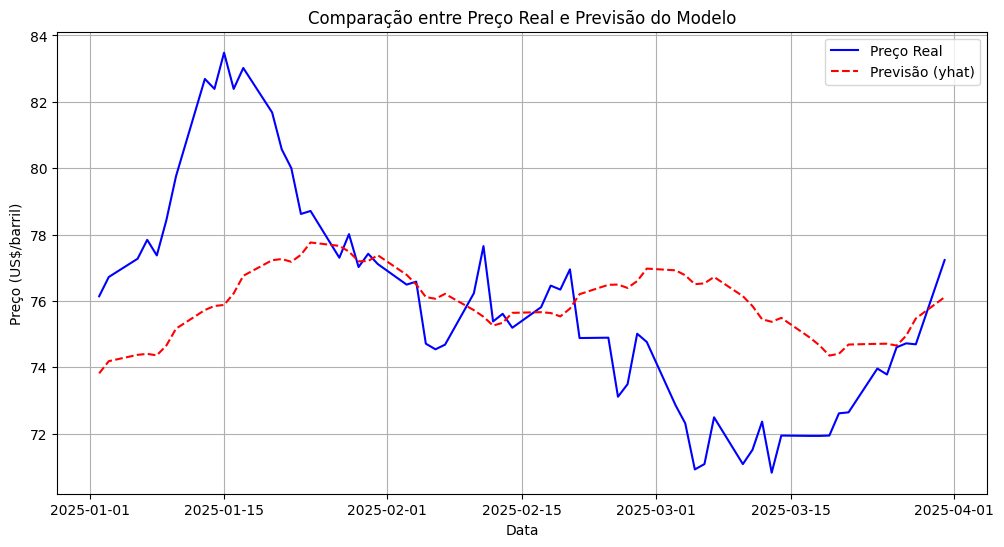

In [53]:
# Plotando o gráfico com os dados do brent e a previsão

# Ordene o DataFrame pela coluna 'Data' para garantir a sequência correta no gráfico
df_brent_forecast_25.sort_values('Data', inplace=True)

# Criação do gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_brent_forecast_25['Data'], 
         df_brent_forecast_25["Preço Brent FOB (US$/barril)_Corrigido"], 
         label='Preço Real', color='blue')
plt.plot(df_brent_forecast_25['Data'], 
         df_brent_forecast_25['yhat'], 
         label='Previsão (yhat)', color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Preço (US$/barril)')
plt.title('Comparação entre Preço Real e Previsão do Modelo')
plt.legend()
plt.grid(True)
plt.show()